Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Verificación de orientación (según orden XML) ===
Total pases considerados: 129
  Adelante (XML): 59
  Atrás (XML):    60
  Empate X:       10
Instancias en las que el 'destino' elegido fue el punto MÁS cercano al arco rival (y no el otro): 60
Jugadores detectados: ['Area Propia', 'Area Rival', 'Ataque Centro', 'Ataque Derecha', 'Ataque Izquierda', 'Defensa Centro', 'Defensa Derecha', 'Defensa Izquierda', 'Mediocampo Centro', 'Mediocampo Derecha', 'Mediocampo Izquierda', 'Perdida X Robo Rival']
Roles detectados: ['ala d', 'ala i', 'pivot']

✅ Exportado: /content/keypasses_myteam_ALL_ALL_vs_Union_Ezpeleta.png


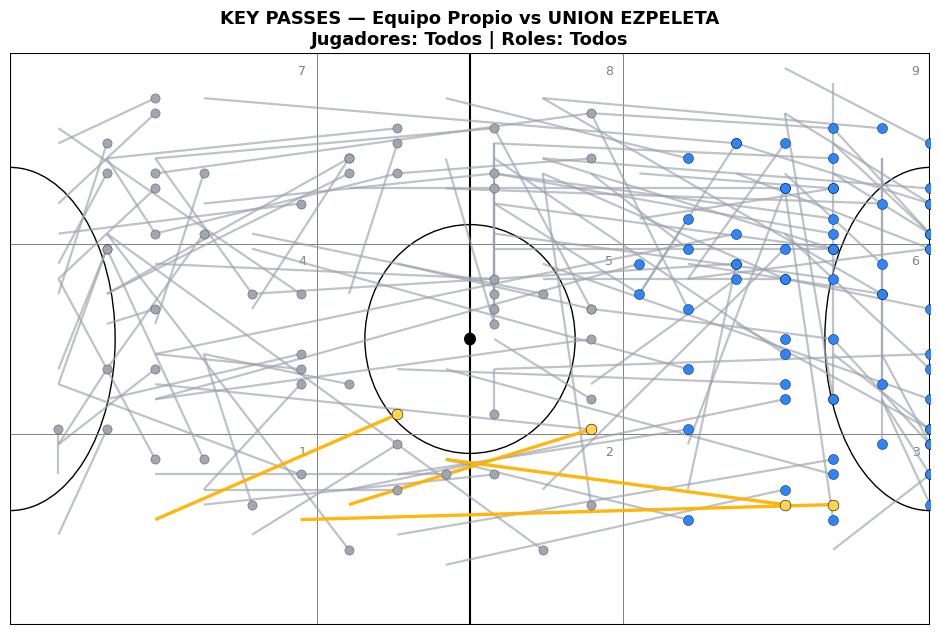

In [3]:
# ============================================================
# KEY PASSES — Por JUGADOR y ROL (Equipo Propio) + Verificación de dirección
# Cancha 35x20 con grilla 3x3 — Google Colab
# ============================================================

# 0) Montar Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

# 1) RUTAS
XML_EQUIPO    = "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Equipo/UnionEzpeletaEq - asXML.xml"
XML_JUGADORES = "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Jugadores/Union Ezpeleta - XML NacSport.xml"
MATRIX_PATH   = "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Jugadores/Union Ezpeleta - Matrix.xlsx"

# 2) PARÁMETROS CANCHA
ANCHO, ALTO = 35, 20
N_COLS, N_ROWS = 3, 3

# 3) CONFIG SELECCIÓN
MYTEAM_ATTACKS_RIGHT = True   # ← si tu equipo atacó hacia la izquierda poné False

# Dejá vacío para "Todos"
PLAYERS_FILTER = []           # ej: ["Juan Pérez", "Gonzalo López"]
ROLES_FILTER   = []           # ej: ["ala d", "ala i", "pivot", "fijo", "cierre", "portero"]

# 4) Imports
import os, re, unicodedata, xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Rectangle, Arc

# 5) Utilidades

def ntext(s):
    if s is None: return ""
    s = str(s)
    s = unicodedata.normalize("NFD", s)
    s = "".join(ch for ch in s if unicodedata.category(ch) != "Mn")
    return s.strip()

def nlower(s):
    return ntext(s).lower()

def infer_opponent(*paths):
    cand = None
    for p in paths:
        if not p: continue
        base = os.path.basename(p); name = os.path.splitext(base)[0]
        parts = [x.strip() for x in re.split(r"\s*-\s*", name)]
        if parts: cand = parts[0]
        cand = re.sub(r"(?i)categoria\s*\-\s*equipo\s*rival", "", cand or "").strip()
        if cand: break
    cand = re.sub(r"([a-z])([A-Z])", r"\1 \2", cand or "")
    cand = re.sub(r"[_]+", " ", cand).strip()
    return cand if cand else "Rival"

def is_rival_code(code):
    return nlower(code).startswith("categoria - equipo rival")

# ---------- PARSE: XML jugadores (guarda TODAS las coordenadas) ----------
def parse_instances_jugadores(xml_path):
    root = ET.parse(xml_path).getroot()
    out, all_x, all_y = [], [], []
    for inst in root.findall(".//instance"):
        code = ntext(inst.findtext("code"))
        try:
            st = float(inst.findtext("start") or "0"); en = float(inst.findtext("end") or "0")
        except:
            continue
        labels = [nlower(t.text) for t in inst.findall("./label/text")]
        xs = [int(x.text) for x in inst.findall("./pos_x") if (x.text or "").isdigit()]
        ys = [int(y.text) for y in inst.findall("./pos_y") if (y.text or "").isdigit()]
        if xs and ys:
            start_xy = (xs[0], ys[0])
            end_xy   = (xs[-1], ys[-1])
            all_x += xs; all_y += ys
        else:
            start_xy = (None, None); end_xy = (None, None)
        out.append({"code": code, "labels": labels, "start": st, "end": en,
                    "xs": xs, "ys": ys, "start_xy": start_xy, "end_xy": end_xy})
    # rango crudo (fallback típico)
    max_x = max(all_x) if all_x else 19
    max_y = max(all_y) if all_y else 34
    return out, max_x, max_y

# ---------- Detectores ----------
def is_pass(ev):
    if re.match(r"^\s*pase\b", nlower(ev["code"])):
        return True
    return any(re.match(r"^\s*pase\b", l) for l in ev["labels"])

ASSIST_PAT   = re.compile(r"\b(asist|asistencia|assist|pase\s*gol|pase\s*de\s*gol)\b", re.IGNORECASE)
KEYPASS_PAT  = re.compile(r"\b(pase\s*clave|key\s*pass|keypass)\b", re.IGNORECASE)

def is_assist(ev):
    s = nlower(ev["code"])
    if ASSIST_PAT.search(s): return True
    return any(ASSIST_PAT.search(l or "") for l in ev["labels"])

def is_key_pass(ev):
    s = nlower(ev["code"])
    if KEYPASS_PAT.search(s): return True
    return any(KEYPASS_PAT.search(l or "") for l in ev["labels"])

# ---------- Jugador y rol (heurística; ajusta si tenés un formato fijo) ----------
ROLE_KEYS = ["ala d", "ala i", "pivot", "pivote", "fijo", "cierre", "portero", "arquero", "gk"]

def extract_player_role(ev):
    """Devuelve (player, role) a partir de labels/código con heurística."""
    labels = [nlower(x) for x in ev["labels"]]
    role = None
    for rk in ROLE_KEYS:
        if any(rk in l for l in labels):
            role = rk; break
        if rk in nlower(ev["code"]):
            role = rk; break

    # jugador: primer label que parezca nombre y no sea keyword conocida
    KNOWN = {"pase", "asistencia", "assist", "key pass", "keypass", "tiro", "remate", "gol"}
    player = None
    for l in labels:
        if any(k in l for k in ROLE_KEYS):
            continue
        if any(k in l for k in KNOWN):
            continue
        if len(l) >= 3 and re.search(r"[a-záéíóúñ]+\s+[a-záéíóúñ]+", l):
            player = l.title()
            break
    return player, role

# ---------- Escalado a cancha 35x20 ----------
def scale_xy(x, y, max_x, max_y):
    if x is None or y is None or max_x == 0 or max_y == 0:
        return None, None
    return x * (ANCHO / float(max_x)), y * (ALTO / float(max_y))

# ---------- Dirección al arco rival (verificación por instancia) ----------
def closer_to_opponent(point_a, point_b, myteam=True):
    """Devuelve cuál punto está más cerca del arco rival (en eje X).
       Si mi equipo ataca a la derecha: mayor X está más cerca del arco rival.
       Si ataca a la izquierda: menor X está más cerca.
    """
    xa, _ = point_a; xb, _ = point_b
    if xa is None or xb is None:
        return None  # no evaluable
    if myteam:
        to_right = MYTEAM_ATTACKS_RIGHT
    else:
        to_right = not MYTEAM_ATTACKS_RIGHT
    # para el equipo que ataca a la derecha: punto con X mayor está más cerca del arco rival
    if to_right:
        return "A" if xa > xb else "B" if xb > xa else "TIE"
    else:
        return "A" if xa < xb else "B" if xb < xa else "TIE"

# 6) Cancha 3x3 (tu función)
def draw_futsal_pitch_grid(ax):
    dx, dy = ANCHO / N_COLS, ALTO / N_ROWS
    ax.set_facecolor("white")
    # bordes + media
    ax.plot([0, ANCHO], [0, 0], color="black")
    ax.plot([0, ANCHO], [ALTO, ALTO], color="black")
    ax.plot([0, 0], [0, ALTO], color="black")
    ax.plot([ANCHO, ANCHO], [0, ALTO], color="black")
    ax.plot([ANCHO/2, ANCHO/2], [0, ALTO], color="black")
    # áreas y círculo central
    ax.add_patch(Arc((0, ALTO/2), 8, 12, angle=0, theta1=270, theta2=90, color="black"))
    ax.add_patch(Arc((ANCHO, ALTO/2), 8, 12, angle=0, theta1=90, theta2=270, color="black"))
    ax.add_patch(plt.Circle((ANCHO/2, ALTO/2), 4, color="black", fill=False))
    ax.add_patch(plt.Circle((ANCHO/2, ALTO/2), 0.2, color="black"))
    # grilla + numeración
    for j in range(N_ROWS):
        for i in range(N_COLS):
            x0, y0 = i * (ANCHO/N_COLS), j * (ALTO/N_ROWS)
            ax.add_patch(Rectangle((x0, y0), ANCHO/N_COLS, ALTO/N_ROWS, linewidth=0.6, edgecolor='gray', facecolor='none'))
            zona = j * N_COLS + i + 1
            ax.text(x0 + (ANCHO/N_COLS) - 0.4, y0 + (ALTO/N_ROWS) - 0.4, str(zona),
                    ha='right', va='top', fontsize=9, color='gray')
    ax.set_xlim(0, ANCHO); ax.set_ylim(0, ALTO); ax.axis('off')

# 7) Recolección + filtros + verificación por instancia
def collect_myteam_passes_by_player_role(xml_players_path, players=(), roles=()):
    evs, max_x, max_y = parse_instances_jugadores(xml_players_path)
    rows = []
    audit_forward, audit_backward, audit_tie = 0, 0, 0
    swapped_count = 0

    found_players = set()
    found_roles   = set()

    for ev in evs:
        if not is_pass(ev):
            continue
        if is_rival_code(ev["code"]):  # solo mi equipo
            continue

        player, role = extract_player_role(ev)
        if player: found_players.add(player)
        if role:   found_roles.add(role)

        # Filtros (si te interesa "Todos", dejá listas vacías)
        if players and (player not in players):
            continue
        if roles and (role not in roles):
            continue

        (x0,y0) = ev["start_xy"]; (x1,y1) = ev["end_xy"]
        if None in (x0,y0,x1,y1):
            continue

        # Escalar
        sx0, sy0 = scale_xy(x0, y0, max_x, max_y)
        sx1, sy1 = scale_xy(x1, y1, max_x, max_y)

        # Verificación de dirección (según arco rival)
        which = closer_to_opponent((sx0,sy0), (sx1,sy1), myteam=True)
        # También calculo sentido "crudo" del XML
        if MYTEAM_ATTACKS_RIGHT:
            forward = (sx1 > sx0)
        else:
            forward = (sx1 < sx0)

        if forward: audit_forward += 1
        elif sx1 != sx0: audit_backward += 1
        else: audit_tie += 1

        # Elegir DESTINO para graficar: el punto más cerca del arco rival (por instancia)
        if which == "A":   # start está más cerca del arco rival
            start_plot = (sx1, sy1)   # el otro punto queda como origen
            end_plot   = (sx0, sy0)
            swapped = True
        elif which == "B": # end está más cerca del arco rival
            start_plot = (sx0, sy0)
            end_plot   = (sx1, sy1)
            swapped = False
        else:              # empate en X → mantenemos XML
            start_plot = (sx0, sy0); end_plot = (sx1, sy1)
            swapped = False

        if swapped: swapped_count += 1

        rows.append({
            "player":  player or "Jugador?",
            "role":    role or "rol?",
            "assist":  is_assist(ev),
            "keypass": is_key_pass(ev),
            "start":   start_plot,
            "end":     end_plot,
            "forward_xml": forward,   # orientación según orden del XML
        })

    audit = {
        "forward_xml": audit_forward,
        "backward_xml": audit_backward,
        "tie_xml": audit_tie,
        "swapped_to_opponent_point": swapped_count,
        "players_found": sorted(found_players),
        "roles_found": sorted(found_roles),
        "total_kept": len(rows),
    }
    return rows, audit

# 8) Plot
def plot_key_passes_myteam_filtered(xml_players_path, players=(), roles=(), save=True):
    opponent = infer_opponent(XML_JUGADORES, XML_EQUIPO, MATRIX_PATH)
    rows, audit = collect_myteam_passes_by_player_role(xml_players_path, players, roles)

    # ---- Reporte de verificación ----
    tot = audit["forward_xml"] + audit["backward_xml"] + audit["tie_xml"]
    print("=== Verificación de orientación (según orden XML) ===")
    print(f"Total pases considerados: {tot}")
    print(f"  Adelante (XML): {audit['forward_xml']}")
    print(f"  Atrás (XML):    {audit['backward_xml']}")
    print(f"  Empate X:       {audit['tie_xml']}")
    print(f"Instancias en las que el 'destino' elegido fue el punto MÁS cercano al arco rival (y no el otro): {audit['swapped_to_opponent_point']}")
    print("Jugadores detectados:", audit["players_found"])
    print("Roles detectados:", audit["roles_found"])
    print()

    # Paleta
    line_grey = "#9BA3AE"
    line_yell = "#FFB300"
    dot_blue  = "#2E86FF"
    dot_grey  = "#A0A7B2"
    dot_yell  = "#FFD54F"

    plt.close("all")
    fig = plt.figure(figsize=(10, 6.5))
    ax  = fig.add_axes([0.04, 0.06, 0.92, 0.88])

    draw_futsal_pitch_grid(ax)

    # Segmentos
    segs_yellow, segs_grey = [], []
    for r in rows:
        (x0,y0) = r["start"]; (x1,y1) = r["end"]
        if r["assist"] or r["keypass"]:
            segs_yellow.append([(x0,y0), (x1,y1)])
        else:
            segs_grey.append([(x0,y0), (x1,y1)])

    if segs_grey:
        ax.add_collection(LineCollection(segs_grey, colors=line_grey, linewidths=1.6, alpha=0.65, zorder=3))
    if segs_yellow:
        ax.add_collection(LineCollection(segs_yellow, colors=line_yell, linewidths=2.4, alpha=0.95, zorder=4))

    # Marcadores en DESTINO (prioridad)
    for r in rows:
        x1,y1 = r["end"]
        if r["assist"]:
            ax.scatter([x1],[y1], marker='*', s=220, c=line_yell, edgecolors="none", zorder=6)
        elif r["keypass"]:
            ax.scatter([x1],[y1], marker='o', s=60,  facecolors=dot_yell, edgecolors="black", linewidths=0.4, zorder=6)
        else:
            # clasificar último tercio por X destino
            last3rd = (x1 >= (2/3)*ANCHO) if MYTEAM_ATTACKS_RIGHT else (x1 <= (1/3)*ANCHO)
            if last3rd:
                ax.scatter([x1],[y1], marker='o', s=52,  facecolors=dot_blue, edgecolors="black", linewidths=0.3, zorder=5)
            else:
                ax.scatter([x1],[y1], marker='o', s=44,  facecolors=dot_grey, edgecolors="black", linewidths=0.2, zorder=4)

    sel_players = ", ".join(players) if players else "Todos"
    sel_roles   = ", ".join(roles) if roles else "Todos"
    ax.set_title(f"KEY PASSES — Equipo Propio vs {opponent.upper()}\nJugadores: {sel_players} | Roles: {sel_roles}",
                 fontsize=13, pad=6, weight="bold")

    if save:
        tag_p = "ALL" if not players else re.sub(r"[^A-Za-z0-9]+", "_", "_".join(players))
        tag_r = "ALL" if not roles   else re.sub(r"[^A-Za-z0-9]+", "_", "_".join(roles))
        out_path = f"/content/keypasses_myteam_{tag_p}_{tag_r}_vs_{opponent.replace(' ','_')}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight", pad_inches=0.05)
        print("✅ Exportado:", out_path)
    plt.show()

# 9) Ejecutar (usa filtros definidos arriba)
if not os.path.exists(XML_JUGADORES):
    raise FileNotFoundError(f"No se encontró el archivo: {XML_JUGADORES}")

# Normalizo filtros a minúsculas
PLAYERS_FILTER = [p.title() for p in PLAYERS_FILTER]
ROLES_FILTER   = [r.lower() for r in ROLES_FILTER]

plot_key_passes_myteam_filtered(XML_JUGADORES, PLAYERS_FILTER, ROLES_FILTER)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Verificación de orientación (según orden del XML) ===
Total pases considerados: 8
  Adelante (XML): 4
  Atrás (XML):    4
  Empate X:       0
Veces que invertimos para usar el punto MÁS cercano al arco rival: 4
Jugadores detectados: ['Bruno', 'Fido', 'JuanBe', 'Toto', 'Vicen', 'Vicente', 'Vito', 'Zurdo']
Roles detectados: ['Ala D', 'Ala I', 'Cierre']

✅ Exportado: /content/keypasses_MYTEAM_JuanBe_Ala_I_vs_Union_Ezpeleta.png


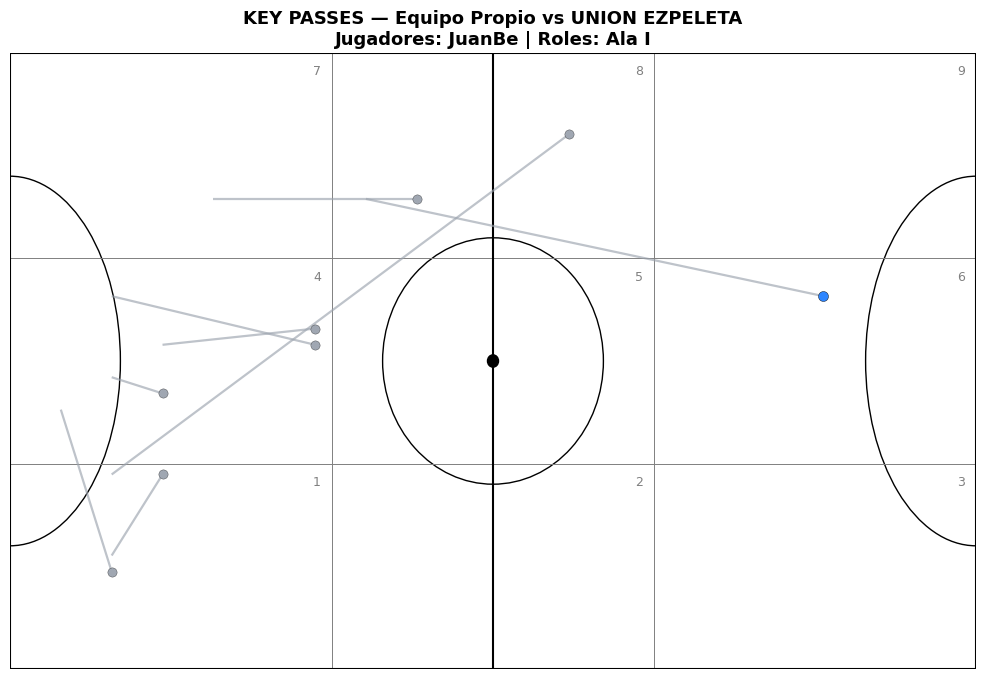

In [7]:
# ============================================================
# KEY PASSES — Por JUGADOR y ROL (Equipo Propio) + verificación de dirección
# Cancha 35x20 (3x3), Google Colab — Usa SOLO roles: Ala I, Ala D, Cierre, Pivot, Arq
# ============================================================

# 0) Montar Drive (en Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

# 1) RUTAS (ajusta si cambia tu carpeta)
XML_EQUIPO    = "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Equipo/UnionEzpeletaEq - asXML.xml"
XML_JUGADORES = "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Jugadores/Union Ezpeleta - XML NacSport.xml"
MATRIX_PATH   = "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Jugadores/Union Ezpeleta - Matrix.xlsx"

# 2) PARÁMETROS DE CANCHA
ANCHO, ALTO = 35, 20
N_COLS, N_ROWS = 3, 3

# 3) CONFIG: dirección de ataque y filtros
MYTEAM_ATTACKS_RIGHT = True   # ← poné False si atacaste hacia la IZQUIERDA

# Dejá listas vacías para ver TODO el equipo
MIS_JUGADORES = ["Vicente", "Brandon", "Zurdo", "Bruno", "JuanBe", "Toto", "Vito", "Fido", "Vicen", "Pepo", "Mateo"]
PLAYERS_FILTER = []            # ej: ["Vicente","Brandon"]  | [] = todos
ROLES_FILTER   = []            # ej: ["Ala I","Pivot"]       | [] = todos

# 4) Imports
import os, re, unicodedata, xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Rectangle, Arc

# 5) Utilidades base
def ntext(s):
    if s is None: return ""
    s = str(s)
    s = unicodedata.normalize("NFD", s)
    s = "".join(ch for ch in s if unicodedata.category(ch) != "Mn")
    return s.strip()

def nlower(s):
    return ntext(s).lower()

def infer_opponent(*paths):
    cand = None
    for p in paths:
        if not p: continue
        base = os.path.basename(p); name = os.path.splitext(base)[0]
        parts = [x.strip() for x in re.split(r"\s*-\s*", name)]
        if parts: cand = parts[0]
        cand = re.sub(r"(?i)categoria\s*\-\s*equipo\s*rival", "", cand or "").strip()
        if cand: break
    cand = re.sub(r"([a-z])([A-Z])", r"\1 \2", cand or "")
    cand = re.sub(r"[_]+", " ", cand).strip()
    return cand if cand else "Rival"

def is_rival_code(code):
    return nlower(code).startswith("categoria - equipo rival")

# ---------- PARSE: XML jugadores (guarda ambas coordenadas y todas las pos) ----------
def parse_instances_jugadores(xml_path):
    root = ET.parse(xml_path).getroot()
    out, all_x, all_y = [], [], []
    for inst in root.findall(".//instance"):
        code = ntext(inst.findtext("code"))
        try:
            st = float(inst.findtext("start") or "0"); en = float(inst.findtext("end") or "0")
        except:
            continue
        labels = [nlower(t.text) for t in inst.findall("./label/text")]
        xs = [int(x.text) for x in inst.findall("./pos_x") if (x.text or "").isdigit()]
        ys = [int(y.text) for y in inst.findall("./pos_y") if (y.text or "").isdigit()]
        if xs and ys:
            start_xy = (xs[0], ys[0])
            end_xy   = (xs[-1], ys[-1])
            all_x += xs; all_y += ys
        else:
            start_xy = (None, None); end_xy = (None, None)
        out.append({"code": code, "labels": labels, "start": st, "end": en,
                    "xs": xs, "ys": ys, "start_xy": start_xy, "end_xy": end_xy})
    max_x = max(all_x) if all_x else 19
    max_y = max(all_y) if all_y else 34
    return out, max_x, max_y

# ---------- Detectores ----------
def is_pass(ev):
    if re.match(r"^\s*pase\b", nlower(ev["code"])):
        return True
    return any(re.match(r"^\s*pase\b", l) for l in ev["labels"])

ASSIST_PAT  = re.compile(r"\b(asist|asistencia|assist|pase\s*gol|pase\s*de\s*gol)\b", re.IGNORECASE)
KEYPASS_PAT = re.compile(r"\b(pase\s*clave|key\s*pass|keypass)\b", re.IGNORECASE)

def is_assist(ev):
    s = nlower(ev["code"])
    if ASSIST_PAT.search(s): return True
    return any(ASSIST_PAT.search(l or "") for l in ev["labels"])

def is_key_pass(ev):
    s = nlower(ev["code"])
    if KEYPASS_PAT.search(s): return True
    return any(KEYPASS_PAT.search(l or "") for l in ev["labels"])

# ---------- Detección de jugador y rol (SOLO lo que pasaste) ----------
_ROLES_CANON = ["Ala I", "Ala D", "Cierre", "Pivot", "Arq"]

def detect_player(ev):
    hay = [nlower(ev["code"])] + [nlower(l) for l in ev["labels"]]
    for name in MIS_JUGADORES:
        nn = nlower(name)
        if any(nn in h for h in hay):
            return name
    return None

def detect_role(ev):
    hay = [nlower(ev["code"])] + [nlower(l) for l in ev["labels"]]
    for rc in _ROLES_CANON:
        if any(nlower(rc) in h for h in hay):
            return rc
    return None

# ---------- Escalado y dirección ----------
def scale_xy(x, y, max_x, max_y):
    if x is None or y is None or max_x == 0 or max_y == 0:
        return None, None
    return x * (ANCHO / float(max_x)), y * (ALTO / float(max_y))

def closer_to_opponent(point_a, point_b, myteam=True):
    xa, _ = point_a; xb, _ = point_b
    if xa is None or xb is None:
        return None
    to_right = MYTEAM_ATTACKS_RIGHT if myteam else (not MYTEAM_ATTACKS_RIGHT)
    if to_right:
        return "A" if xa > xb else "B" if xb > xa else "TIE"
    else:
        return "A" if xa < xb else "B" if xb < xa else "TIE"

# ---------- Cancha 3x3 (tu función) ----------
def draw_futsal_pitch_grid(ax):
    dx, dy = ANCHO / N_COLS, ALTO / N_ROWS
    ax.set_facecolor("white")
    # bordes + media
    ax.plot([0, ANCHO], [0, 0], color="black")
    ax.plot([0, ANCHO], [ALTO, ALTO], color="black")
    ax.plot([0, 0], [0, ALTO], color="black")
    ax.plot([ANCHO, ANCHO], [0, ALTO], color="black")
    ax.plot([ANCHO/2, ANCHO/2], [0, ALTO], color="black")
    # áreas y círculo central
    ax.add_patch(Arc((0, ALTO/2), 8, 12, angle=0, theta1=270, theta2=90, color="black"))
    ax.add_patch(Arc((ANCHO, ALTO/2), 8, 12, angle=0, theta1=90, theta2=270, color="black"))
    ax.add_patch(plt.Circle((ANCHO/2, ALTO/2), 4, color="black", fill=False))
    ax.add_patch(plt.Circle((ANCHO/2, ALTO/2), 0.2, color="black"))
    # grilla + numeración (izq→der, abajo→arriba)
    for j in range(N_ROWS):
        for i in range(N_COLS):
            x0, y0 = i * dx, j * dy
            ax.add_patch(Rectangle((x0, y0), dx, dy, linewidth=0.6, edgecolor='gray', facecolor='none'))
            zona = j * N_COLS + i + 1
            ax.text(x0 + dx - 0.4, y0 + dy - 0.4, str(zona), ha='right', va='top', fontsize=9, color='gray')
    ax.set_xlim(0, ANCHO); ax.set_ylim(0, ALTO); ax.axis('off')

# ---------- Espejo vertical de Y para Alas ----------
def mirror_y_by_role(y, role):
    if y is None:
        return None
    if role in ("Ala I", "Ala D"):
        return ALTO - y
    return y

# ---------- Recolección (filtros por jugador/rol, usa SOLO roles canónicos) ----------
def collect_myteam_passes_by_player_role(xml_players_path, players=(), roles=()):
    evs, max_x, max_y = parse_instances_jugadores(xml_players_path)
    rows = []
    audit_forward, audit_backward, audit_tie = 0, 0, 0
    swapped_count = 0
    found_players, found_roles = set(), set()

    for ev in evs:
        if not is_pass(ev):
            continue
        if is_rival_code(ev["code"]):  # solo mi equipo
            continue

        player = detect_player(ev)
        role   = detect_role(ev)

        # Solo aceptamos roles EXACTOS de la lista (por pedido explícito)
        if role not in _ROLES_CANON:
            continue

        if player: found_players.add(player)
        if role:   found_roles.add(role)

        # Filtros (vacío = TODOS)
        if players and (player not in players):
            continue
        if roles and (role not in roles):
            continue

        x0,y0 = ev["start_xy"]; x1,y1 = ev["end_xy"]
        if None in (x0,y0,x1,y1):
            continue

        # Escalar
        sx0, sy0 = scale_xy(x0, y0, max_x, max_y)
        sx1, sy1 = scale_xy(x1, y1, max_x, max_y)

        # Espejo Y para alas (Ala I/Ala D)
        sy0 = mirror_y_by_role(sy0, role)
        sy1 = mirror_y_by_role(sy1, role)

        # Orientación en XML (solo a modo de auditoría)
        forward_xml = (sx1 > sx0) if MYTEAM_ATTACKS_RIGHT else (sx1 < sx0)
        if forward_xml: audit_forward += 1
        elif sx1 != sx0: audit_backward += 1
        else: audit_tie += 1

        # Destino elegido = punto MÁS cercano al arco rival (por X)
        which = closer_to_opponent((sx0,sy0), (sx1,sy1), myteam=True)
        if which == "A":
            start_plot = (sx1, sy1)
            end_plot   = (sx0, sy0)
            swapped_count += 1
        elif which == "B":
            start_plot = (sx0, sy0)
            end_plot   = (sx1, sy1)
        else:  # TIE
            start_plot = (sx0, sy0)
            end_plot   = (sx1, sy1)

        rows.append({
            "player":  player or "Jugador?",
            "role":    role,
            "assist":  is_assist(ev),
            "keypass": is_key_pass(ev),
            "start":   start_plot,
            "end":     end_plot,
            "forward_xml": forward_xml,
        })

    audit = {
        "forward_xml": audit_forward,
        "backward_xml": audit_backward,
        "tie_xml": audit_tie,
        "swapped_to_opponent_point": swapped_count,
        "players_found": sorted(found_players),
        "roles_found": sorted(found_roles),
        "total_kept": len(rows),
    }
    return rows, audit

# ---------- Plot ----------
def plot_key_passes_myteam_filtered(xml_players_path, players=(), roles=(), save=True):
    opponent = infer_opponent(XML_JUGADORES, XML_EQUIPO, MATRIX_PATH)
    rows, audit = collect_myteam_passes_by_player_role(xml_players_path, players, roles)

    # Auditoría rápida
    tot = audit["forward_xml"] + audit["backward_xml"] + audit["tie_xml"]
    print("=== Verificación de orientación (según orden del XML) ===")
    print(f"Total pases considerados: {tot}")
    print(f"  Adelante (XML): {audit['forward_xml']}")
    print(f"  Atrás (XML):    {audit['backward_xml']}")
    print(f"  Empate X:       {audit['tie_xml']}")
    print(f"Veces que invertimos para usar el punto MÁS cercano al arco rival: {audit['swapped_to_opponent_point']}")
    print("Jugadores detectados:", audit["players_found"])
    print("Roles detectados:", audit["roles_found"])
    print()

    # Paleta
    line_grey = "#9BA3AE"
    line_yell = "#FFB300"
    dot_blue  = "#2E86FF"
    dot_grey  = "#A0A7B2"
    dot_yell  = "#FFD54F"

    plt.close("all")
    fig = plt.figure(figsize=(10.5, 7))
    ax  = fig.add_axes([0.04, 0.06, 0.92, 0.88])

    draw_futsal_pitch_grid(ax)

    # Segmentos
    segs_yellow, segs_grey = [], []
    for r in rows:
        (x0,y0) = r["start"]; (x1,y1) = r["end"]
        if r["assist"] or r["keypass"]:
            segs_yellow.append([(x0,y0), (x1,y1)])
        else:
            segs_grey.append([(x0,y0), (x1,y1)])

    if segs_grey:
        ax.add_collection(LineCollection(segs_grey, colors=line_grey, linewidths=1.6, alpha=0.65, zorder=3))
    if segs_yellow:
        ax.add_collection(LineCollection(segs_yellow, colors=line_yell, linewidths=2.4, alpha=0.95, zorder=4))

    # Marcadores en DESTINO (prioridad: asistencia > key pass > último tercio > resto)
    for r in rows:
        x1,y1 = r["end"]

        # Último tercio por X destino (depende del sentido de ataque)
        last3rd = (x1 >= (2/3)*ANCHO) if MYTEAM_ATTACKS_RIGHT else (x1 <= (1/3)*ANCHO)

        if r["assist"]:
            ax.scatter([x1],[y1], marker='*', s=220, c=line_yell, edgecolors="none", zorder=6)        # ⭐
        elif r["keypass"]:
            ax.scatter([x1],[y1], marker='o', s=60,  facecolors=dot_yell, edgecolors="black", linewidths=0.4, zorder=6)
        elif last3rd:
            ax.scatter([x1],[y1], marker='o', s=52,  facecolors=dot_blue, edgecolors="black", linewidths=0.3, zorder=5)
        else:
            ax.scatter([x1],[y1], marker='o', s=44,  facecolors=dot_grey, edgecolors="black", linewidths=0.2, zorder=4)

    sel_players = ", ".join(players) if players else "Todos"
    sel_roles   = ", ".join(roles)   if roles   else "Todos"
    ax.set_title(f"KEY PASSES — Equipo Propio vs {opponent.upper()}\nJugadores: {sel_players} | Roles: {sel_roles}",
                 fontsize=13, pad=6, weight="bold")

    if save:
        tag_p = "ALL" if not players else re.sub(r"[^A-Za-z0-9]+", "_", "_".join(players))
        tag_r = "ALL" if not roles   else re.sub(r"[^A-Za-z0-9]+", "_", "_".join(roles))
        out_path = f"/content/keypasses_MYTEAM_{tag_p}_{tag_r}_vs_{opponent.replace(' ','_')}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight", pad_inches=0.05)
        print("✅ Exportado:", out_path)
    plt.show()

# 6) Ejecutar con filtros
if not os.path.exists(XML_JUGADORES):
    raise FileNotFoundError(f"No se encontró el archivo: {XML_JUGADORES}")

# Normalizo entradas de filtros (usa las cadenas EXACTAS de MIS_JUGADORES y roles canónicos)
PLAYERS_FILTER = [p for p in PLAYERS_FILTER if p in MIS_JUGADORES]
PLAYERS_FILTER = ["JuanBe"]
ROLES_FILTER   = [r for r in ROLES_FILTER if r in _ROLES_CANON]
ROLES_FILTER = ["Ala I"]
plot_key_passes_myteam_filtered(XML_JUGADORES, PLAYERS_FILTER, ROLES_FILTER)
